In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from importlib import reload

In [4]:
import dataset_utils
from glob import glob

In [5]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [6]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [7]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            #  filtered_data.append([0,0,0])
            # points_removed.append(point)
    return filtered_data

In [63]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_train_points.append(bg_rm_arr)
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                # concatenated_train_points = background_subtraction(background_data, concatenated_train_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_test_points.append(bg_rm_arr)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                # concatenated_test_points = background_subtraction(background_data, concatenated_test_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                
                test_points.append(sampled_data)
                test_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
                # print(test_labels)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [64]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: picking_up
processing class: jumping
processing class: sitting
train_points shape: (1073, 300, 5)
test_points shape: (269, 300, 5)
train_labels shape: (1073,)
test_labels shape: (269,)


In [65]:
print(CLASS_MAP)

{0: 'walking', 1: 'picking_up', 2: 'jumping', 3: 'sitting'}


In [66]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [99]:
train_size = 0.8
seed = 42
BATCH_SIZE = 32
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(1)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [100]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [69]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features, NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)



In [70]:

model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
model.summary()

Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 300, 32)   │        192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 32)   │        128 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 300, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 300, 64)   │      2,112 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 64)   │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 300, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 300, 512)  │     33,280 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 512)  │      2,048 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 300, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_20[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 25)        │      3,225 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 5, 5)      │          0 │ dense_12[0][0]  

 Total params: 3,112,925 (11.87 MB)

 Trainable params: 3,108,381 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [72]:
INIT_TIMESTAMP = "testing"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [76]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [77]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks= [checkpoint_callback, early_stopping_callback]  
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 6.2974 - sparse_categorical_accuracy: 0.7070
Epoch 1: val_loss improved from inf to 3.98841, saving model to model/checkpoints/testing/best.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 6.2546 - sparse_categorical_accuracy: 0.7118 - val_loss: 3.9884 - val_sparse_categorical_accuracy: 0.9767
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 4.2468 - sparse_categorical_accuracy: 0.9606
Epoch 2: val_loss did not improve from 3.98841
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 4.2474 - sparse_categorical_accuracy: 0.9601 - val_loss: 4.4758 - val_sparse_categorical_accuracy: 0.8186
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 4.2963 - sparse_categorical_accuracy: 0.9457
Epoch 3: val_loss improved from 3.98841 to 3.97062, saving model to model/checkpoints/testing/best.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 4.2946 - sparse_categorical_accuracy: 0.9459 - val_loss: 3.

In [78]:
from matplotlib import pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[[[ 4.7949e-01  2.8789e+00  1.6045e+00  1.2524e-01  1.7500e+02]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  ...
  [ 6.1816e-01  1.7500e+00  4.9707e-01 -3.7573e-01  2.4600e+02]
  [ 5.5859e-01  2.6465e+00  8.4180e-01 -6.2598e-01  2.1900e+02]
  [ 6.6357e-01  2.7852e+00  1.4160e+00 -2.5049e-01  3.4700e+02]]

 [[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [-2.7637e-01  1.2979e+00  6.6309e-01 -2.5049e-01  4.1100e+02]
  ...
  [ 1.6553e-01  1.7920e+00  6.4453e-01 -5.0098e-01  2.4600e+02]
  [-1.0449e-01  1.3682e+00  6.0938e-01  2.5049e-01  2.9400e+02]
  [ 1.2158e-01  1.4863e+00  7.7539e-01 -2.5049e-01  3.7600e+02]]

 [[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+0

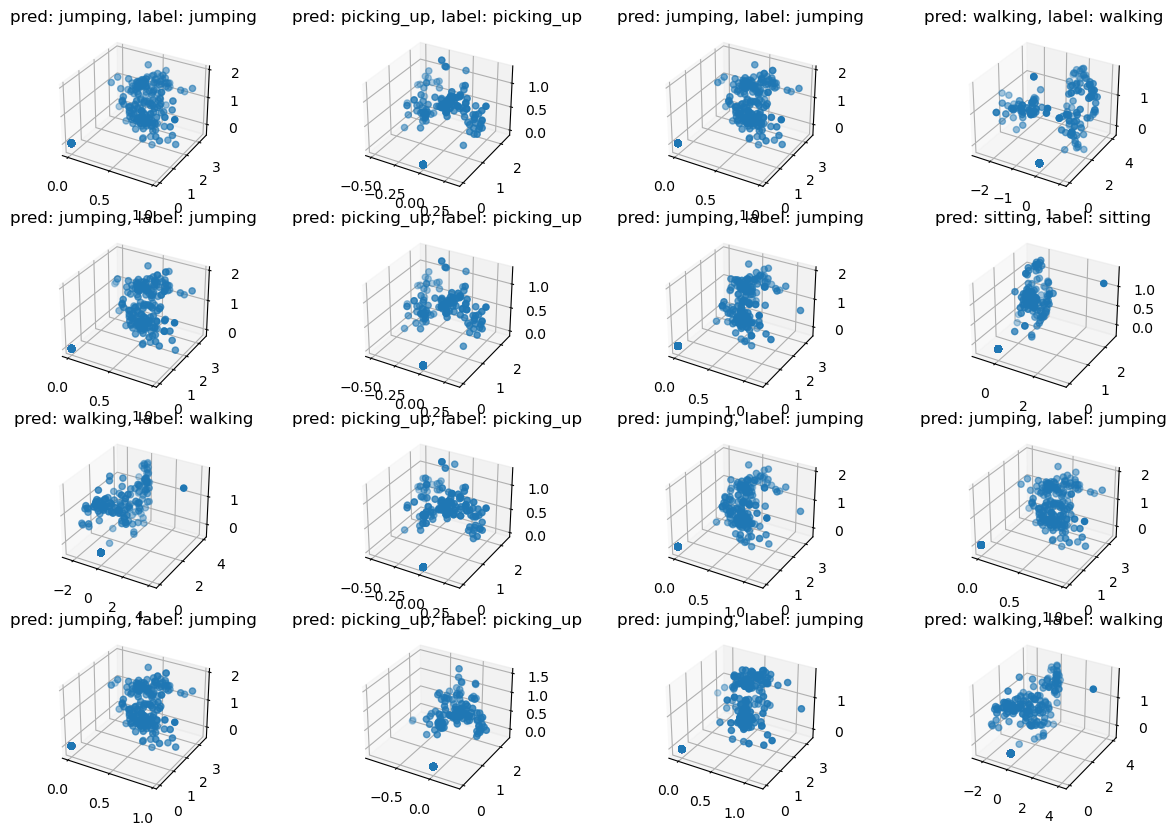

In [79]:
data = test_dataset.take(16)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
preds = preds.numpy()
labels = labels.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
num_points_to_plot = min(len(points), 16)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [80]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)
    print("argmax is", preds)
    predictions.extend(preds)

predictions = np.array(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
pred is [[6.5462803e-04 2.2032256e-04 9.9827522e-01 8.4989442e-04]
 [9.9038899e-01 8.5162017e-03 8.8438141e-04 2.1042733e-04]
 [9.9850649e-01 7.5323181e-04 6.2727218e-04 1.1299528e-04]
 ...
 [6.2681170e-04 5.1651620e-03 2.8231624e-03 9.9138486e-01]
 [6.7683851e-04 1.0953513e-02 2.5613885e-03 9.8580819e-01]
 [6.7719130e-04 1.0972583e-02 2.5609280e-03 9.8578936e-01]]
(269, 300, 5)
argmax is [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3]


In [81]:
predictions = []
true_label = []

# Iterate over the test_dataset to make predictions
for batch, label in test_dataset:
    preds = model.predict(batch)  # Get predictions for the current batch
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
    print("argmax is", preds)
    predictions.extend(preds)  # Extend the predictions list with the results
    true_label.extend(label)

true_label = np.array(true_label)
predictions = np.array(predictions)  # Convert predictions to a numpy array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
pred is [[3.45175649e-04 1.29596694e-04 9.98737037e-01 7.88184581e-04]
 [9.98406291e-01 8.23250914e-04 6.59046811e-04 1.11413188e-04]
 [3.04102403e-04 1.19522163e-04 9.98833776e-01 7.42533593e-04]
 [9.98130500e-01 8.13433377e-04 9.29032569e-04 1.27103267e-04]
 [6.51204609e-04 4.90256120e-03 2.78498442e-03 9.91661191e-01]
 [6.77191303e-04 1.09725762e-02 2.56092777e-03 9.85789299e-01]
 [1.28115795e-03 9.95377064e-01 3.36911704e-04 3.00485967e-03]
 [3.45193490e-04 1.29386084e-04 9.98738587e-01 7.86813325e-04]
 [2.45659699e-04 1.34534552e-04 9.98883069e-01 7.36705086e-04]
 [9.98148143e-01 8.62720713e-04 8.61776702e-04 1.27386942e-04]
 [2.97889637e-04 1.30214452e-04 9.98784184e-01 7.87602621e-04]
 [1.42335193e-03 9.96947408e-01 2.71212688e-04 1.35787658e-03]
 [3.46850633e-04 1.36056697e-04 9.98704076e-01 8.13049031e-04]
 [9.98534918e-01 8.46852956e-04 5.45719871e-04 7.25531427e-05]
 [6.25499815e-04 5.43405814e-03 2.78057833e-03 9.91159856e-01]
 [1.27040

In [82]:
accuracy = np.sum(predictions == true_label) / len(true_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.51%


In [83]:
print(predictions)

[2 0 2 0 3 3 1 2 2 0 2 1 2 0 3 1 2 3 0 1 0 0 0 2 3 3 1 3 0 0 2 0 0 0 0 2 3
 0 2 0 0 0 2 3 1 1 0 0 2 0 0 0 0 0 3 2 0 2 0 0 0 3 1 2 0 0 0 0 0 0 2 2 0 2
 3 1 0 2 2 1 0 1 0 3 1 3 2 2 0 2 0 0 0 0 0 0 1 0 3 0 3 3 3 3 0 0 0 2 1 2 2
 0 1 0 0 0 2 0 0 3 0 3 0 1 2 2 0 2 2 2 0 0 0 1 1 3 2 1 2 2 0 0 2 0 0 2 2 0
 2 2 2 0 1 0 0 0 3 2 2 0 0 0 1 0 0 3 0 0 2 0 0 1 2 0 0 2 1 0 0 3 0 2 2 0 1
 2 0 2 2 0 2 0 2 2 0 0 3 1 2 1 0 0 2 3 2 0 2 0 0 1 0 1 0 2 0 0 1 3 1 0 2 1
 2 2 2 2 1 2 2 1 1 0 2 2 2 0 0 0 0 2 2 0 1 2 0 0 0 1 0 3 2 0 0 0 2 0 2 1 0
 0 2 0 2 2 2 0 0 0 2]


In [84]:
print(true_label)

[2 0 2 0 3 3 1 2 2 0 2 1 2 1 3 1 2 3 0 1 0 0 0 2 3 3 1 3 0 0 2 0 0 0 0 2 3
 0 2 0 0 0 2 3 1 1 0 0 2 0 0 0 0 0 3 2 0 2 0 0 0 3 1 2 0 0 0 0 0 0 2 2 0 2
 3 1 0 2 2 1 0 1 0 3 1 3 2 2 0 2 0 0 0 0 0 0 1 0 3 0 3 3 3 3 0 0 0 2 1 2 2
 0 1 0 0 0 2 0 0 3 1 3 0 1 2 2 0 0 2 2 0 0 0 1 1 3 2 1 2 2 0 0 2 0 0 2 2 0
 2 2 2 0 1 0 0 0 3 2 2 0 0 0 1 0 0 3 0 0 2 0 0 1 2 0 0 2 1 0 0 3 0 2 2 0 1
 2 0 2 2 0 2 0 2 2 0 0 3 1 2 1 0 0 2 3 2 0 2 0 0 1 0 1 0 2 0 0 1 3 1 0 2 1
 2 2 2 2 1 2 2 1 1 1 2 2 2 0 0 0 0 2 2 0 1 2 0 0 0 1 0 3 2 0 0 0 2 0 2 1 0
 0 2 0 2 2 2 0 0 0 2]


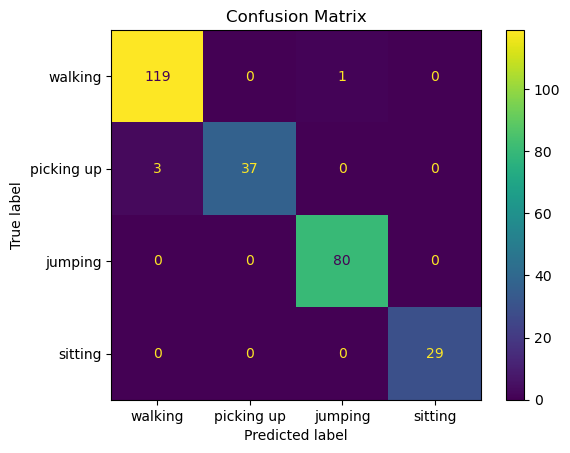

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(true_label, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [107]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
reload_model.load_weights('./model/checkpoints/testing/best.weights.h5')

In [108]:
predictions = []
true_label = []

# Iterate over the test_dataset to make predictions
for batch, label in test_dataset:
    preds = reload_model.predict(batch)  # Get predictions for the current batch
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
    print("argmax is", preds)
    predictions.extend(preds)  # Extend the predictions list with the results
    true_label.extend(label)

true_label = np.array(true_label)
predictions = np.array(predictions)  # Convert predictions to a numpy array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
pred is [[3.2652388e-04 1.3616669e-04 9.9869871e-01 8.3856517e-04]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
pred is [[2.1437390e-03 9.9639529e-01 2.9764400e-04 1.1633636e-03]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[3.4519398e-04 1.2938608e-04 9.9873859e-01 7.8681257e-04]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
pred is [[9.9656337e-01 9.5630897e-04 2.1560632e-03 3.2417808e-04]]
(1, 300, 5)
argmax is [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[3.5378154e-04 1.3568184e-04 9.9869931e-01 8.1127923e-04]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred is [[2.040122e-03 9.964869e-01 2.922108e-04 1.180741e-03]]
(1, 300, 5)
argmax is [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[2.99963314e-04 1.20729164e-04 9.98830855e-01 7.48481136e-04]]
(1, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[6.7719101e-04 1.0972567e-02

In [109]:
accuracy = np.sum(predictions == true_label) / len(true_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.51%


In [110]:
print(predictions)

[2 1 2 0 2 1 2 3 0 1 2 2 2 1 2 0 0 0 2 1 3 1 0 2 3 0 0 0 0 0 0 2 1 2 2 0 1
 2 0 0 0 2 0 2 3 2 2 3 2 0 3 2 0 0 0 0 3 0 2 0 0 3 1 2 0 0 0 3 0 0 0 2 1 0
 2 1 2 0 0 0 0 3 1 0 0 1 0 3 2 0 0 0 3 0 2 2 2 2 1 0 2 2 0 2 2 0 0 2 2 2 0
 3 1 0 0 0 0 2 2 2 2 0 0 0 0 0 0 3 1 2 2 2 0 2 2 0 2 0 1 0 2 1 2 1 1 0 2 0
 3 3 1 0 0 2 0 2 3 0 2 0 1 3 0 1 2 0 2 0 2 0 3 3 0 0 0 1 0 0 2 2 2 2 2 0 0
 0 0 1 3 3 0 0 0 3 3 2 2 1 1 0 0 1 1 1 0 2 0 0 0 0 0 0 2 2 0 2 0 2 0 2 0 2
 1 0 0 2 2 0 0 0 1 0 0 0 0 2 0 0 0 2 3 1 1 0 0 2 2 0 1 0 0 2 0 2 0 0 0 2 2
 3 3 0 0 2 3 1 3 0 1]


In [111]:
print(true_label)

[2 1 2 0 2 1 2 3 0 1 2 2 2 1 2 0 0 0 2 1 3 1 0 2 3 0 0 0 0 0 0 2 1 2 2 0 1
 2 0 0 0 2 0 2 3 2 2 3 2 0 3 2 0 1 0 0 3 0 2 0 0 3 1 2 0 0 0 3 0 0 0 2 1 0
 2 1 2 0 0 0 0 3 1 0 0 1 0 3 2 0 0 0 3 0 2 2 2 2 1 0 2 2 1 2 2 0 0 2 2 2 0
 3 1 0 0 0 0 2 2 2 2 0 0 0 0 0 0 3 1 2 2 2 0 2 2 0 2 0 1 0 2 1 2 1 1 0 2 0
 3 3 1 0 0 2 0 2 3 0 2 0 1 3 0 1 2 0 2 0 2 0 3 3 0 0 0 1 0 0 2 2 2 2 2 0 0
 0 0 1 3 3 0 0 0 3 3 2 2 1 1 0 1 1 1 1 0 2 0 0 0 0 0 0 0 2 0 2 0 2 0 2 0 2
 1 0 0 2 2 0 0 0 1 0 0 0 0 2 0 0 0 2 3 1 1 0 0 2 2 0 1 0 0 2 0 2 0 0 0 2 2
 3 3 0 0 2 3 1 3 0 1]


In [142]:
def class_preds(DATA_DIR, model):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    predictions = []
    for f in files:
        try:
            with open(f, 'rb') as file:
                
                data = pickle.load(file)
                test_points = []
                sample_test_points = []
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sample_test_points.append(bg_rm_arr)
                
                data = np.concatenate(sample_test_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(data.shape[0], size=300, replace=True)
                sampled_data = data[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                # train_labels.append(i)
                # data = np.array(data).reshape(1,300,5)
                test_points = np.array(test_points)
                preds = model.predict(test_points)  # Get predictions for the current batch
                print("pred is", preds)
                print(batch.shape)
                preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
                print("argmax is", preds)
                predictions.extend(preds)  # Extend the predictions list with the results
        except Exception as e:
            print(f"Error processing file {f}: {e}")

    predictions = np.array(predictions)
    return predictions


In [144]:
# Specify your test directory
test_files = './cluster_data/padded/walking/test'
predictions = class_preds(test_files, reload_model)
# print(len(predictions))
accuracy = np.sum(predictions == 0) / len(predictions)
print(accuracy)

300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred is [[6.5462763e-04 2.2032254e-04 9.9827516e-01 8.4989477e-04]]
(1, 300, 5)
argmax is [2]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
pred is [[8.1432201e-03 9.9002761e-01 5.5695238e-04 1.2722289e-03]]
(1, 300, 5)
argmax is [1]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred is [[3.0772554e-04 3.6592240e-04 9.9729282e-01 2.0335740e-03]]
(1, 300, 5)
argmax is [2]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
pred is [[2.3772669e-04 2.7787581e-04 9.9797839e-01 1.5060245e-03]]
(1, 300, 5)
argmax is [2]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
pred is [[1.0310656e-03 9.9715829e-01 2.6147542e-04 1.5491433e-03]]
(1, 300, 5)
argmax is [1]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
pred is [[1.2975361e-03 9.9633861e-01 2.8705838e-04 2.0768081e-03]]
(1, 300, 5)
argmax is [1]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
pred is [[3.9681485e-03 3.6845065e-04 9.9450570e-01 1.1577158e-03]]
(1, 300, 5)
argmax is [2]
300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred i